In [7]:
import glob
import numpy as np
import datetime
import pandas as pd
from matplotlib import pyplot as plt
from matplotlib.colors import Normalize
from scipy.signal import butter, filtfilt, find_peaks, stft
from skimage.restoration import denoise_wavelet

import cv2



In [8]:
def set_axis(x: np.ndarray, no_labels: int = 7)->tuple[np.ndarray, np.ndarray]:
    """Sets the x-axis positions and labels for a plot.

    Args:
        x (np.array): The x-axis data.
        no_labels (int, optional): The number of labels to display. Defaults to 7.

    Returns:
        tuple[np.array, np.array]: A tuple containing:
            - The positions of the labels on the x-axis.
            - The labels themselves.
    """
    nx = x.shape[0]
    step_x = int(nx / (no_labels - 1)) 
    x_positions = np.arange(0,nx,step_x) 
    x_labels = x[::step_x]
    return x_positions, x_labels

def automedian(img: np.ndarray, struct: np.ndarray) -> np.ndarray:
    img_O = cv2.morphologyEx(img, cv2.MORPH_OPEN, struct)
    img_CO = cv2.morphologyEx(img_O, cv2.MORPH_CLOSE, struct)
    img_OCO = cv2.morphologyEx(img_CO, cv2.MORPH_OPEN, struct)

    img_C = cv2.morphologyEx(img, cv2.MORPH_CLOSE, struct)
    img_OC = cv2.morphologyEx(img_C, cv2.MORPH_OPEN, struct)
    img_COC = cv2.morphologyEx(img_OC, cv2.MORPH_CLOSE, struct)
    img_Q = np.minimum(img, img_COC)

    img_A = np.maximum(img_Q, img_OCO)

    return img_A

def plt_imshow(df: pd.DataFrame, lines=None, norm=None):
    aspect_ratio = df.shape[1] / df.shape[0]
    fig = plt.figure(figsize=(8,8))
    ax = plt.axes()
    cax = fig.add_axes((ax.get_position().x1+0.06,ax.get_position().y0,0.02,ax.get_position().height))
    x_positions, x_labels = set_axis(df.columns)
    ax.set_xticks(x_positions, np.round(x_labels))
    y_positions, y_labels = set_axis(df.index.time)
    ax.set_yticks(y_positions, y_labels)
    im = ax.imshow(df,interpolation='none',aspect='auto', norm=norm)
    plt.colorbar(im, cax=cax)

    plt.ylabel('time')
    plt.xlabel('space [m]') 
    if lines is not None:
        height, width = df.shape
        # for l in lines:
        #     rho = l[0][0]
        #     theta = l[0][1]
        #     a = np.cos(theta)
        #     b = np.sin(theta)
        #     x0 = a * rho
        #     y0 = b * rho
        #     # Points far outside image bounds for visualization
        #     x1 = np.clip(x0 + 2000*(-b), 0, width-1)
        #     y1 = np.clip(y0 + 2000*(a), 0, height-1)
        #     x2 = np.clip(x0 - 2000*(-b), 0, width-1)
        #     y2 = np.clip(y0 - 2000*(a), 0, height-1)
        #     # Plot lines on axes (swap x/y if needed for image orientation)
        #     ax.plot([x1, x2], [y1, y2], color='red', linewidth=1)
    if lines is not None:
        for l in lines:
            rho = l[0][0]
            theta = l[0][1]
            a = np.cos(theta)
            b = np.sin(theta)
            # Compute endpoints at left and right borders
            x0 = 0
            y0 = (rho - x0 * a) / b if abs(b) > 1e-6 else 0
            x1 = width
            y1 = (rho - x1 * a) / b if abs(b) > 1e-6 else height
            # Only plot segments inside image
            ax.plot([x0, x1], [y0, y1], color='red', linewidth=1)

In [9]:
path_out = 'train_data/'
files = glob.glob(path_out+"*")
files.sort()

In [10]:
dx = 5.106500953873407
dt = 0.0016

data = []
my_first_filename = 'train_data/091222.npy'
first_id = 0
for idx, filename in enumerate(files):
    if filename == my_first_filename:
        first_id = idx
first_filename = files[first_id]
for file in files[first_id:first_id+12]:
    data.append(np.load(file))
data = np.concatenate(data).astype(np.float32)
time_start = datetime.datetime.strptime(
    '2024-05-07 ' + first_filename.split("/")[-1].split(".")[0], "%Y-%m-%d %H%M%S")
index = pd.date_range(start=time_start, periods=len(data), freq=f'{dt}s')

columns = np.arange(len(data[0])) * dx

base_df = pd.DataFrame(data=data, index=index, columns=columns)



In [11]:
def plot_fft(df, col_id, dt, xlim=300):
    """Plot FFT spectrum at a spatial position."""
    spatial_pos = df.columns[col_id]
    signal = df[spatial_pos].values
    fft_result = np.fft.fft(signal)
    fft_freqs = np.fft.fftfreq(len(signal), d=dt)
    pos_freqs = fft_freqs[:len(signal)//2]
    pos_mags = np.abs(fft_result[:len(signal)//2])
    plt.plot(pos_freqs, pos_mags)
    plt.xlabel('Frequency [Hz]')
    plt.ylabel('Amplitude')
    plt.title(f'Frequency spectrum at {spatial_pos:.1f} m')
    plt.xlim(0, xlim)
    xticks = np.arange(0, xlim+10, 10)
    plt.xticks(xticks)
    plt.xticks(rotation=-90)
    plt.show()


def plot_average_freq_spectrum(filtered_df, dt, col_start=None, col_end=None):
    """
    Plots the average frequency spectrum over selected spatial columns.

    Parameters:
      filtered_df: pandas DataFrame, rows=time, cols=space
      dt: time step (seconds)
      col_start: first column index to include (inclusive)
      col_end: last column index to include (exclusive)
      title: custom plot title (optional)
      xlim: x-axis frequency limit for plot (optional, tuple)
    """
    avg_signal = filtered_df.iloc[:, col_start:col_end].mean(axis=1).values
    fft_result = np.fft.fft(avg_signal)
    fft_freqs = np.fft.fftfreq(len(avg_signal), d=dt)
    positive_freqs = fft_freqs[:len(avg_signal)//2]
    positive_mags = np.abs(fft_result[:len(avg_signal)//2])

    plt.plot(positive_freqs, positive_mags)
    plt.xlabel("Frequency [Hz]")
    plt.ylabel("Amplitude")
    title_substring = "all" if col_start is None or col_end is None else f"{col_start} to {col_end-1}"
    plt.title(f"Average Frequency Spectrum for columns: {title_substring}")

    plt.show()

# https://www.geeksforgeeks.org/data-science/signal-filtering-with-scipy/


def butter_bandpass_filter(data, lowcut, highcut, fs, order=4):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = butter(order, [low, high], btype='band')
    return filtfilt(b, a, data)


def filter_df_combine_bands(df, bands, dt, order=4):
    """
    Filter a DataFrame so that only the given bands are present (sum their filters).
    bands: list of (low, high) frequency tuples
    Returns: a DataFrame containing the sum of all filtered bands.
    """
    fs = 1 / dt
    result = np.zeros_like(df.to_numpy())
    for low, high in bands:
        filtered = df.apply(lambda col: butter_bandpass_filter(
            col.values, low, high, fs, order), axis=0)
        result += filtered.to_numpy()
    return pd.DataFrame(result, index=df.index, columns=df.columns)


def filter_df_band(df, low, high, dt, order=4):
    fs = 1 / dt
    return df.apply(lambda col: butter_bandpass_filter(col.values, low, high, fs, order), axis=0)


def denoise_df(df: pd.DataFrame, dt: float) -> pd.DataFrame:
    out = {}
    N = df.shape[0]

    for col in df.columns:
        signal = df[col].values
        fft_result = np.fft.fft(signal)
        fft_mags = np.abs(fft_result[:N//2])

        # Adaptive threshold: 20% of max magnitude in this channel
        min_height = 0.3 * fft_mags.max()
        peaks, _ = find_peaks(fft_mags, height=min_height)

        # Mask for all FFT bins (positive and negative frequencies)
        mask = np.zeros_like(fft_result, dtype=bool)
        mask[peaks] = True
        # Mirror peaks for negative frequencies (indices > 0)
        mask[-peaks] = True

        # Keep only peak frequencies (zero out the rest)
        fft_cleaned = np.where(mask, fft_result, 0)
        signal_denoised = np.fft.ifft(fft_cleaned).real
        out[col] = signal_denoised

    # Compose result as DataFrame, keep same column order and index
    result = pd.DataFrame(out, index=df.index)
    return result

def wavelet_denoise_signal(signal, wavelet='db1', method='BayesShrink', mode='soft'):
    # scikit-image supports 1D signals since v0.19
    return denoise_wavelet(
        signal,
        wavelet=wavelet,
        method=method,
        mode=mode,
        rescale_sigma=True
    )

def wavelet_denoise_df(df: pd.DataFrame, wavelet='Haar', method='BayesShrink', mode='hard') -> pd.DataFrame:
    out = {}
    for col in df.columns:
        out[col] = wavelet_denoise_signal(df[col].values, wavelet, method, mode)
    return pd.DataFrame(out, index=df.index)

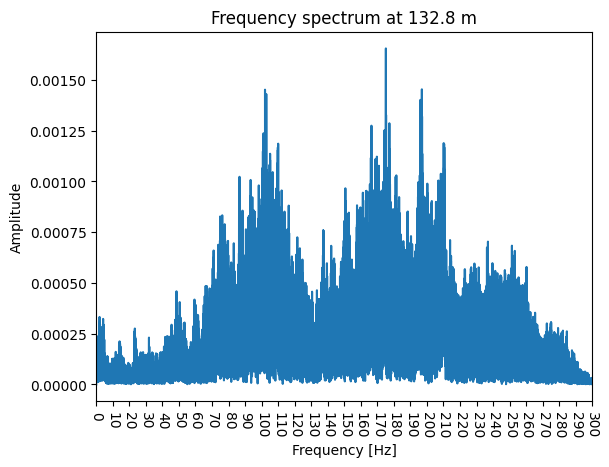

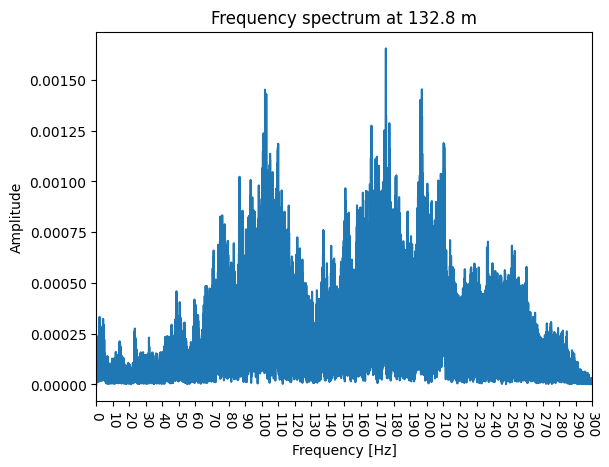

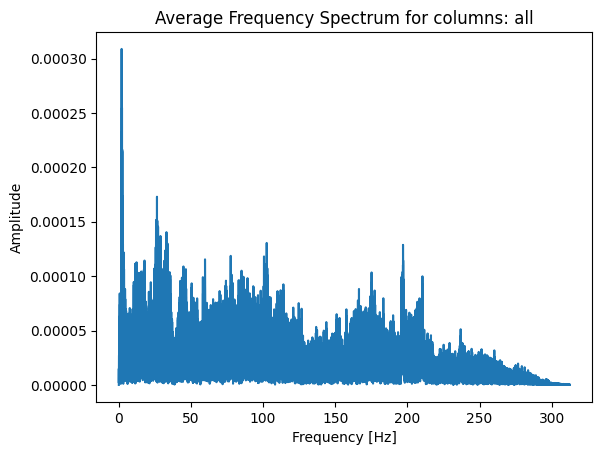

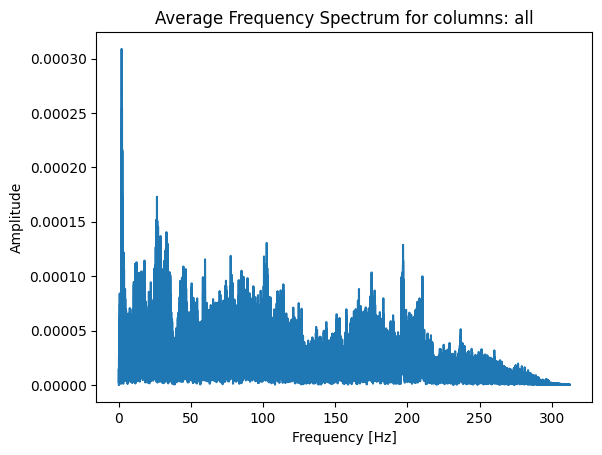

In [12]:
col_id = 26

# bands = [(40, 60), (75, 90), (100, 110),(160, 190)]
# bands=[(10, 15),(40, 60),(80,95) ,(100,120),(160, 180), (198,215)]
# bands=[(30, 300)]
# base_df -= base_df.mean()
# base_df = np.abs(base_df)
# filtered_df = filter_df_combine_bands(base_df, bands, dt)
base_df -= base_df.mean()

# filtered_df = filter_df_band(base_df, 3, 280, dt)
filtered_df = wavelet_denoise_df(base_df)

plot_fft(base_df, col_id, dt)
plot_fft(filtered_df, col_id, dt)
plot_average_freq_spectrum(base_df, dt)
plot_average_freq_spectrum(filtered_df, dt)



In [13]:
from skimage.transform import resize

def preprocess_df(df: pd.DataFrame) -> pd.DataFrame:
    # df = df.iloc[::10, :]  # Every 10th time sample, all columns
    # df = df.resample('0.16S').mean()
    
    data = df.to_numpy(dtype=np.float32)
    # data = (data - data.mean()) / data.std()
    data = cv2.normalize(data, None, 0, 255, cv2.NORM_MINMAX).astype(np.uint8)
    # data = cv2.equalizeHist(data)
    # clahe = cv2.createCLAHE(clipLimit=30.0, tileGridSize=(8,8))
    # data = clahe.apply(data)
    # data = cv2.bilateralFilter(data, 9, 75, 75) #https://docs.opencv.org/4.x/d4/d13/tutorial_py_filtering.html
    # data = cv2.GaussianBlur(data,(5,5),cv2.BORDER_DEFAULT)
    # data = cv2.medianBlur(data, 11)
    new_shape = (400,400)
    start = df.index[0]
    end = df.index[-1]
    new_times = pd.date_range(start, end, periods=new_shape[0])
    data = resize(data, new_shape, anti_aliasing=True)
    data = cv2.normalize(data, None, 0, 255, cv2.NORM_MINMAX).astype(np.uint8)

    processed_df = pd.DataFrame(data, index=new_times)
    return processed_df

def find_edges_canny(df: pd.DataFrame, threshold1:float, threshold2:float) -> pd.DataFrame:
    data = df.to_numpy(dtype=np.uint8)
    bins = np.array([0, 4,16, 32,64, 128, 192, 256])
    quantized = np.digitize(data, bins) - 1  # bin indices (0 to 3)
    quantized_img = quantized * (255 // (len(bins) - 1))
    # _, edges = cv2.threshold(data, thresh=8, maxval=255, type=cv2.THRESH_BINARY)
    # edges = cv2.Canny(data, threshold1,threshold2, None)
    # edges = cv2.morphologyEx(edges, cv2.MORPH_CLOSE, np.ones((5,5), np.uint8))
    # edges = cv2.morphologyEx(edges, cv2.MORPH_OPEN, np.ones((5,5), np.uint8))
    # return edges
    return quantized_img.astype(np.uint8)

def plot_hough_linesP_on_black(img, lines, norm, title="", ax=None):
    # If ax is None, create a new figure and axis (for standalone use)
    if ax is None:
        plt.figure(figsize=(12, 8))
        ax = plt.gca()

    ax.imshow(img, cmap='viridis', aspect='auto', norm=norm)
    if lines is not None:
        for line in lines:
            x1, y1, x2, y2 = line
            ax.plot([x1, x2], [y1, y2], color='r', linewidth=0.5)

    ax.set_title(title)
    ax.axis('off')
    
# base_df -= base_df.mean()
base_df = np.abs(base_df)

# filtered_df -= filtered_df.mean()
filtered_df = np.abs(filtered_df)

dfs = [base_df, filtered_df]
pp_dfs = [preprocess_df(df) for df in dfs]
all_dfs = dfs + pp_dfs

norms = []
for df in all_dfs:
    low, high = np.percentile(df, [3, 99])
    norms.append(Normalize(vmin=low, vmax=high, clip=True))




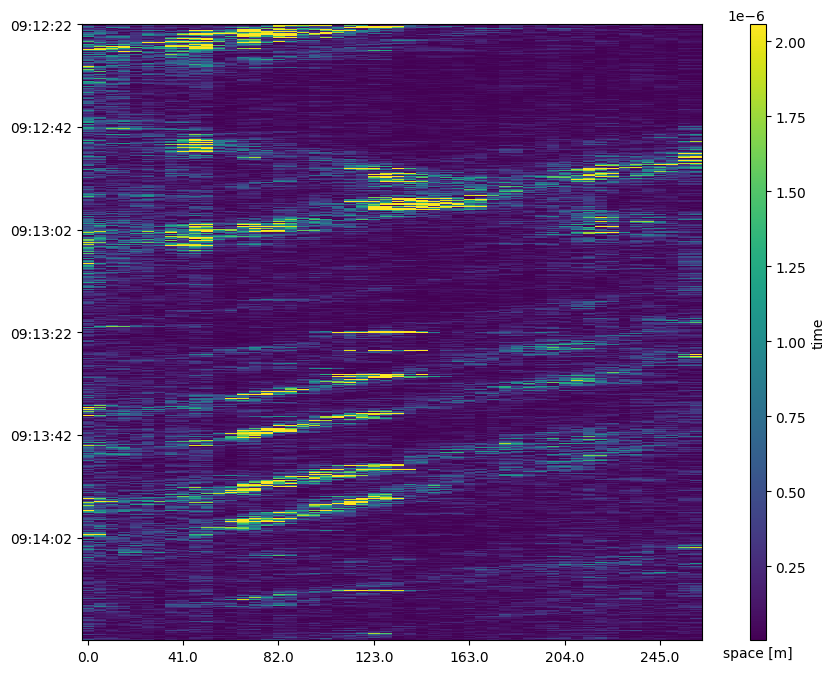

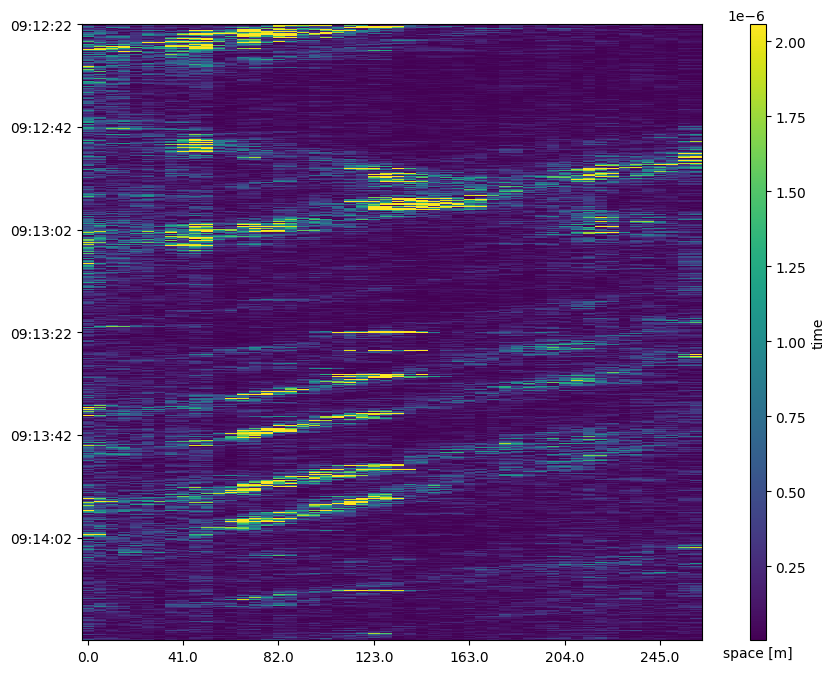

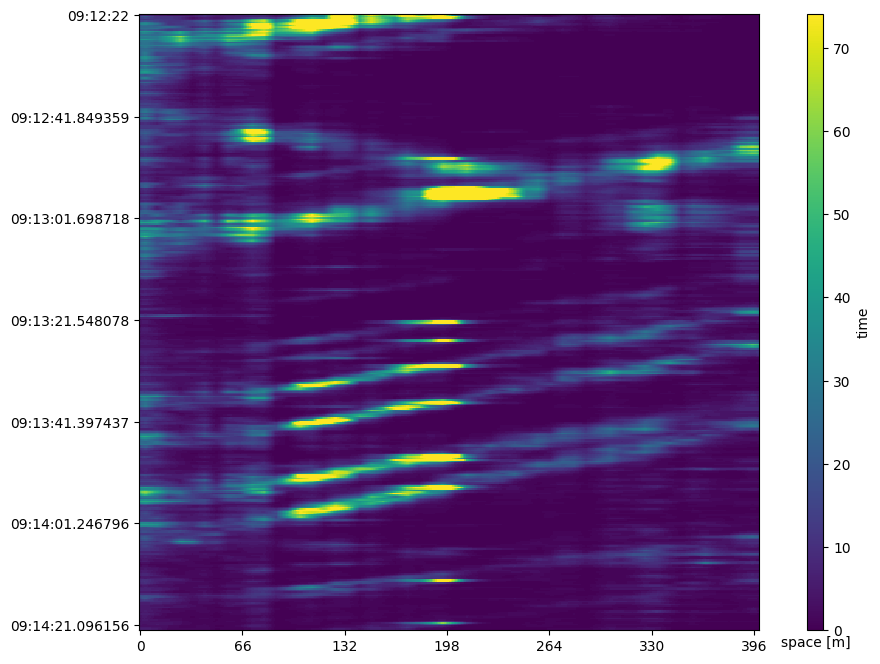

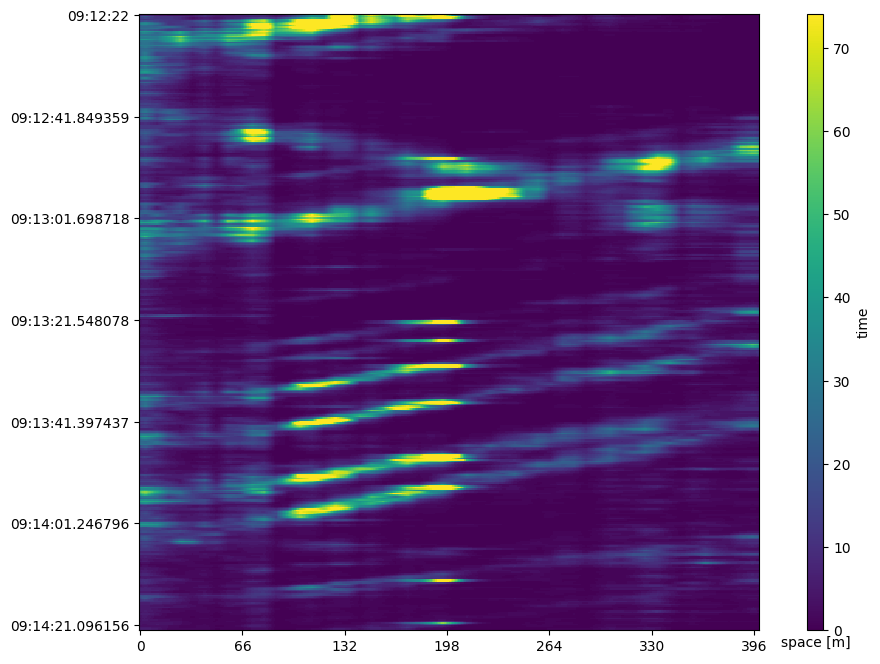

In [14]:
for df, norm in zip(all_dfs, norms):
    plt_imshow(df, lines=None, norm=norm)
# plt_imshow(pp_dfs[0], lines=None, norm=norms[2])
# plt_imshow(pp_dfs[1], lines=None, norm=norms[3])
# pp_dfs[1].shape

In [15]:
edges_base = find_edges_canny(pp_dfs[0], 100, 200)
edges_filtered = find_edges_canny(pp_dfs[1], 100, 200)

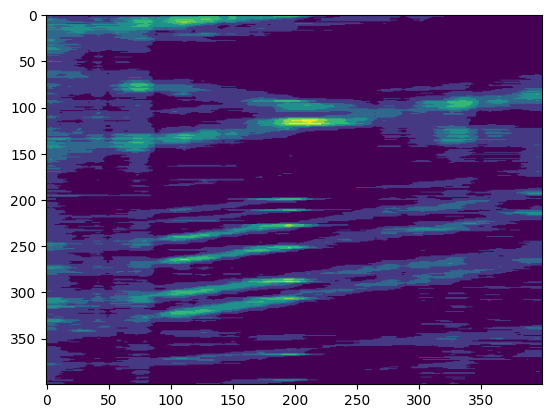

In [16]:
plt.imshow(edges_base, aspect='auto')

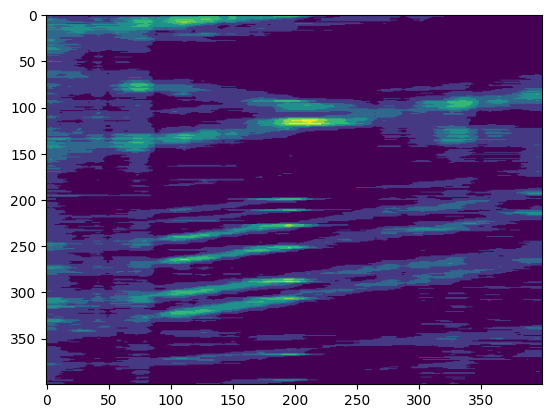

In [17]:
plt.imshow(edges_filtered, aspect='auto')


In [18]:
lines_base = cv2.HoughLinesP(
    edges_base,           # edge image
    rho=1,           # distance resolution in pixels
    theta=np.pi/180,  # angle resolution in radians
    threshold=80,    # minimum number of intersecting points to detect a line
    minLineLength=240,  # minimum length of line (in pixels)
    maxLineGap=75    # maximum allowed gap between line segments to treat them as one line
)

lines_filtered = cv2.HoughLinesP(
    edges_filtered,           # edge image
    rho=1,           # distance resolution in pixels
    theta=np.pi/180,  # angle resolution in radians
    threshold=80,    # minimum number of intersecting points to detect a line
    minLineLength=240,  # minimum length of line (in pixels)
    maxLineGap=75    # maximum allowed gap between line segments to treat them as one line
)

if lines_base is not None:
    lines_base = lines_base.reshape(-1, 4)
if lines_filtered is not None:
    lines_filtered = lines_filtered.reshape(-1, 4)


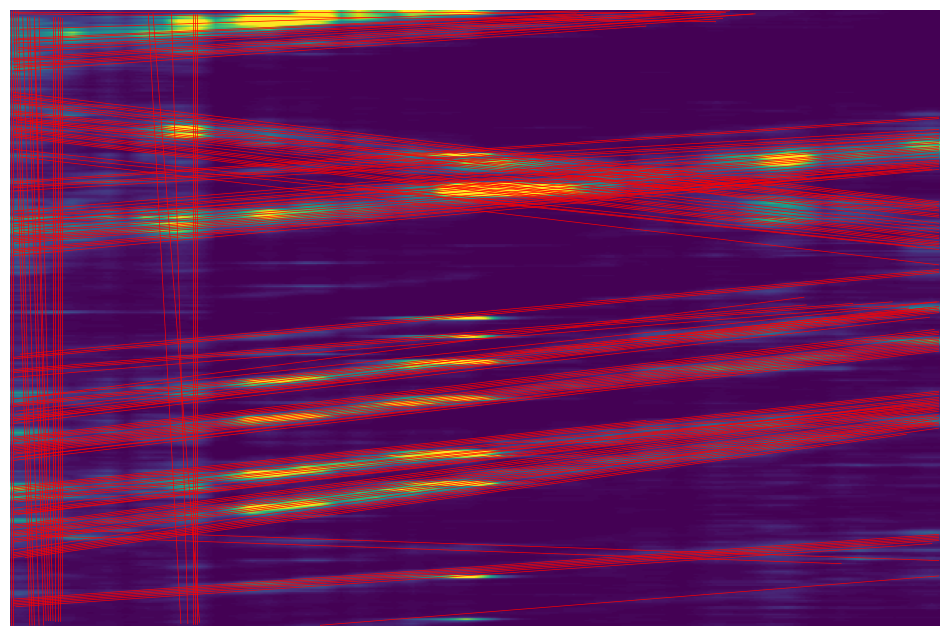

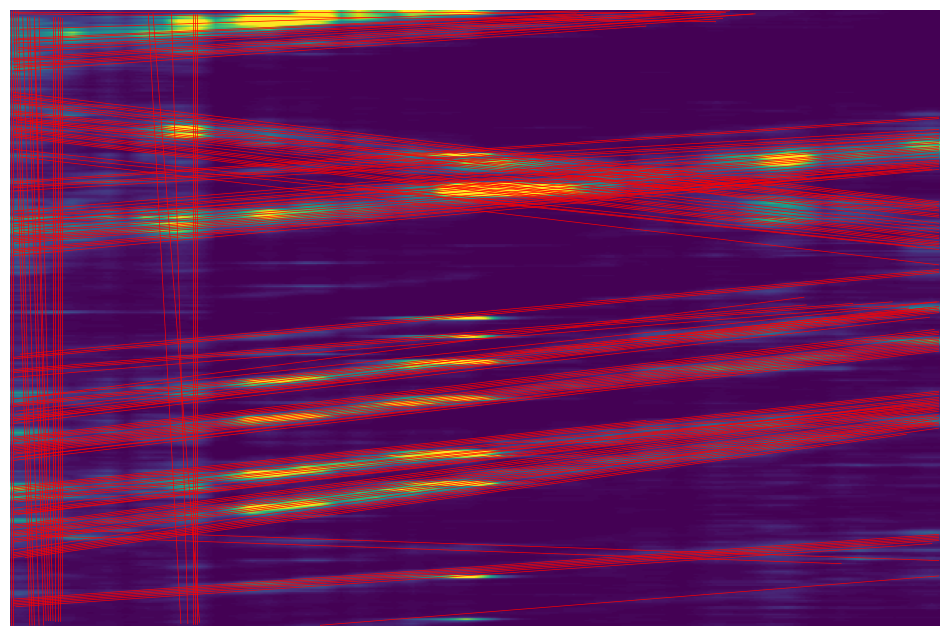

In [19]:
plot_hough_linesP_on_black(pp_dfs[0].to_numpy(),lines_base, norm=norms[2])
plot_hough_linesP_on_black(pp_dfs[1].to_numpy(),lines_filtered, norm=norms[3])


In [20]:
def filter_vertical_lines(lines, angle_threshold=10):
    """
    Remove lines within angle_threshold of vertical (90 deg).
    angle_threshold: degrees from 90 to consider "vertical".
    """
    result = []
    for x1, y1, x2, y2 in lines:
        dx = x2 - x1
        dy = y2 - y1
        if dx == 0:
            angle = 90
        else:
            angle = np.degrees(np.arctan2(dy, dx))
        # Consider vertical if angle is close to 90 or -90
        if not (90-angle_threshold <= abs(angle) <= 90+angle_threshold):
            result.append((x1, y1, x2, y2))
    return result

def line_angle(line):
    x1, y1, x2, y2 = line
    return np.arctan2(y2 - y1, x2 - x1)

def line_center(line):
    x1, y1, x2, y2 = line
    return ((x1 + x2)/2, (y1 + y2)/2)

def merge_lines(lines, angle_thresh=0.1, center_thresh=30, length=None):
    used = [False] * len(lines)
    clusters = []

    for i, line in enumerate(lines):
        if used[i]:
            continue
        group = [line]
        a1 = line_angle(line)
        c1 = line_center(line)
        used[i] = True
        for j in range(i + 1, len(lines)):
            if used[j]:
                continue
            a2 = line_angle(lines[j])
            c2 = line_center(lines[j])
            if abs(a1 - a2) < angle_thresh and np.linalg.norm(np.array(c1) - np.array(c2)) < center_thresh:
                group.append(lines[j])
                used[j] = True
        clusters.append(group)
    
    merged = []
    for group in clusters:
        angles = [line_angle(l) for l in group]
        centers = [line_center(l) for l in group]
        # Average center
        cx, cy = np.mean(centers, axis=0)
        # Average angle
        angle = np.mean(angles)
        # Optionally: Calculate mean length
        if length is None:
            lengths = [np.linalg.norm([l[2]-l[0], l[3]-l[1]]) for l in group]
            L = np.mean(lengths)
        else:
            L = length
        # Construct merged line endpoints
        dx = np.cos(angle) * L / 2
        dy = np.sin(angle) * L / 2
        x1, y1 = cx - dx, cy - dy
        x2, y2 = cx + dx, cy + dy
        merged.append([x1, y1, x2, y2])
    return np.array(merged)




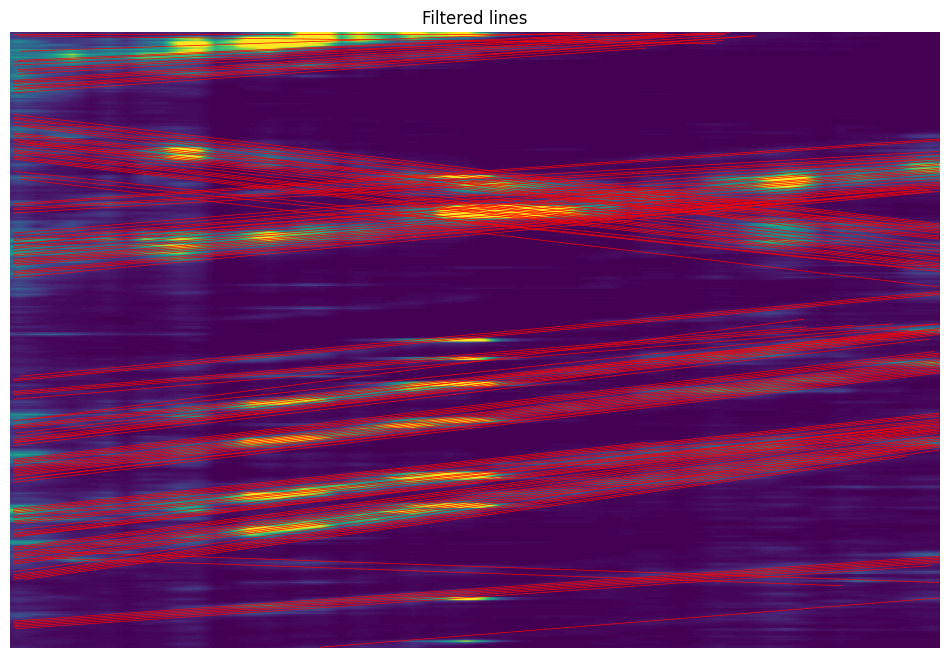

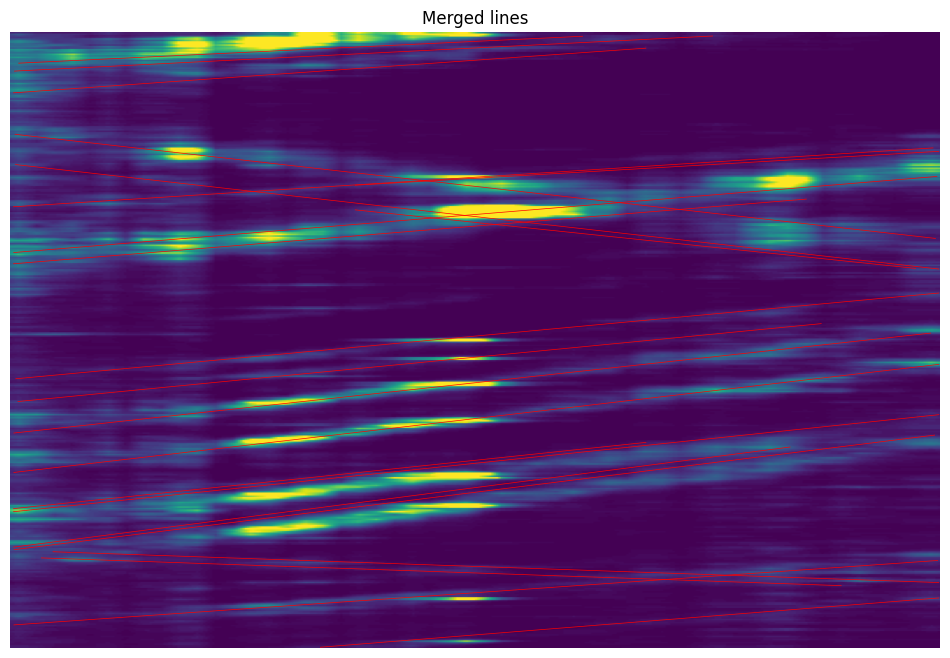

In [21]:
filtered_lines = filter_vertical_lines(lines_base, angle_threshold=10)
merged_lines = merge_lines(filtered_lines, angle_thresh=0.1, center_thresh=20)

plot_hough_linesP_on_black(pp_dfs[0].to_numpy(),filtered_lines, norms[2],"Filtered lines")
plot_hough_linesP_on_black(pp_dfs[0].to_numpy(),merged_lines, norms[2],"Merged lines")

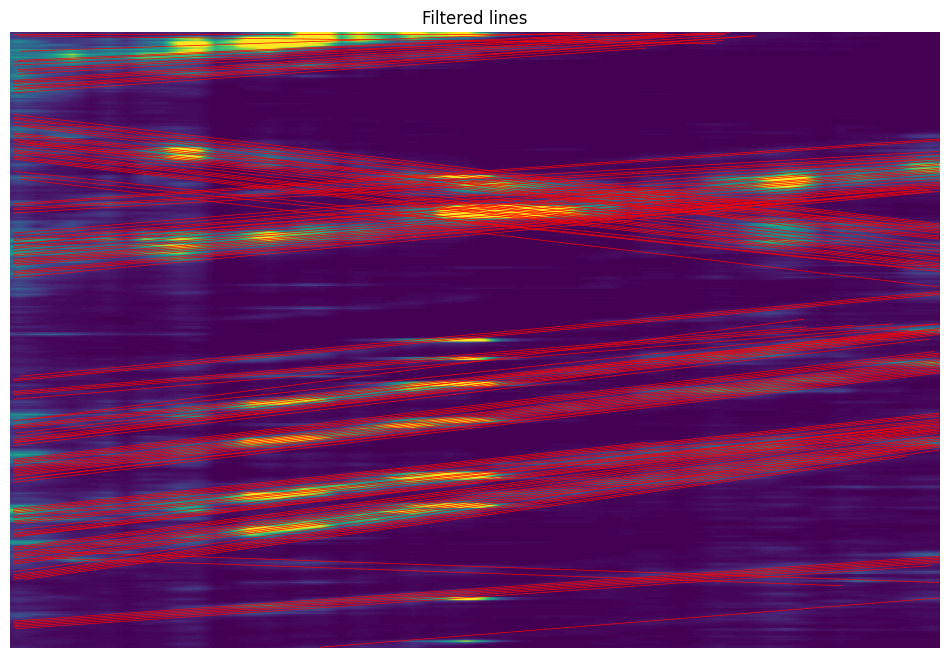

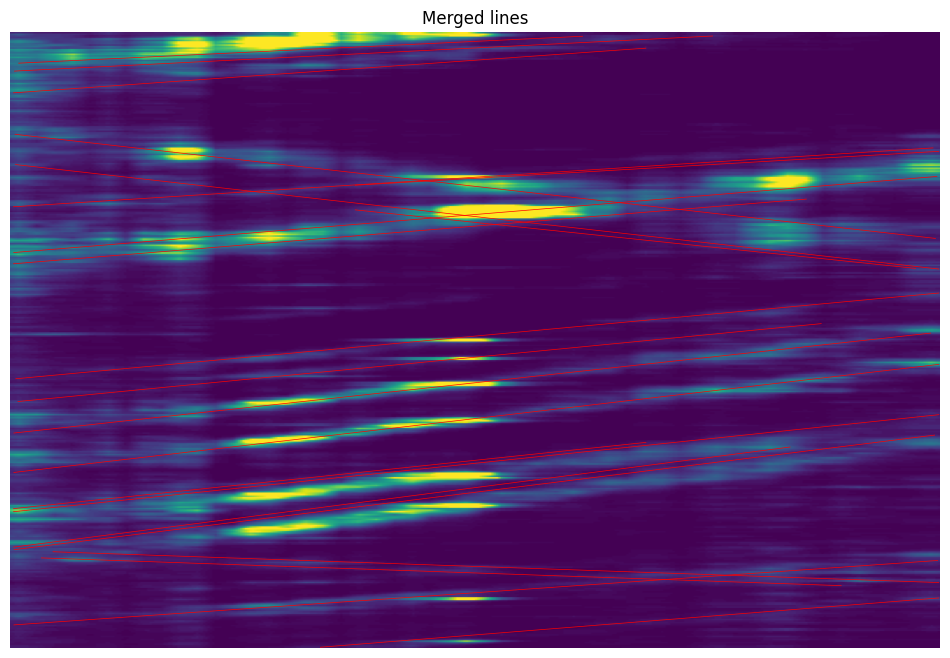

In [22]:
filtered_lines = filter_vertical_lines(lines_filtered, angle_threshold=10)
merged_lines = merge_lines(filtered_lines, angle_thresh=0.1, center_thresh=20)

plot_hough_linesP_on_black(pp_dfs[0].to_numpy(),filtered_lines, norms[2],"Filtered lines")
plot_hough_linesP_on_black(pp_dfs[0].to_numpy(),merged_lines, norms[2],"Merged lines")

In [23]:
def compare_hough_parameters(
    img,
    norm,
    edges,
    thresholds=[20, 30, 50, 80],
    min_lengths=[60, 120, 180, 240],
    max_gaps=[10, 25, 50, 75]
):
    nrows = len(thresholds)
    ncols = len(min_lengths) * len(max_gaps)
    fig, axes = plt.subplots(nrows, ncols, figsize=(4 * ncols, 3 * nrows))
    for i, threshold in enumerate(thresholds):
        idx = 0
        for min_len in min_lengths:
            for max_gap in max_gaps:
                lines = cv2.HoughLinesP(
                    edges,
                    rho=1,
                    theta=np.pi/180,
                    threshold=threshold,
                    minLineLength=min_len,
                    maxLineGap=max_gap
                )
                title = f"Thresh={threshold}\nMinLen={min_len} Gap={max_gap}\nDetected={len(lines) if lines is not None else 0}"
                ax = axes[i, idx]
                idx += 1

                plot_hough_linesP_on_black(img, lines=lines.reshape(-1, 4) if lines is not None else lines, norm=norm, title=title, ax=ax)
    plt.tight_layout()
    plt.show()

In [24]:
# compare_hough_parameters(pp_dfs[0], norms[2], edges_base)

In [25]:
# compare_hough_parameters(pp_dfs[1], norms[3], edges_filtered)


In [26]:
#https://stackoverflow.com/questions/71425968/remove-horizontal-lines-with-open-cv possibly interesting
# https://docs.opencv.org/3.2.0/d1/dee/tutorial_moprh_lines_detection.html